# Spam Classifier

### **Exercise : Build a spam classifier with a fair trade-off between precision and recall**

From A. Guéron, "Hands-On Machine Learning with Scikit-Learn & TensorFlow", O'Reilly, 2017.
<br>
Chapter 3 - Classification. Notebook of the author available 
[here](https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb)

#### *Key skills* : Text analysis, bag of words, regular expression, ntlk, binary classification**

### **Set up**

#### **Importing librairies**

In [1]:
import sys
import os
import tarfile
from six.moves import urllib
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display #to have nice dataframe in Jupyter notebook

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, accuracy_score

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import EnglishStemmer

import warnings

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghare\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ghare\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
print("Python interpreter : ", sys.version)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Seaborn version: ", sns.__version__)
print("Matplotlib version: ", matplotlib.__version__)
print("Scikit-learn version: ", sklearn.__version__)
print("NTLK version: ", nltk.__version__)

Python interpreter :  3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
Numpy version:  1.16.3
Pandas version:  0.24.2
Seaborn version:  0.9.0
Matplotlib version:  3.0.3
Scikit-learn version:  0.20.3
NTLK version:  3.4.1


In [3]:
plt.style.use('ggplot')
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 500)
warnings.simplefilter("ignore", category=FutureWarning)
MODEL_SAVING_PATH = "./Models/"

#### **Downloading the data**

In [4]:
DOWNLOAD_ROOT = 'https://spamassassin.apache.org/old/publiccorpus/'
FILE_NAMES = ['20030228_easy_ham.tar.bz2', 
              '20030228_easy_ham_2.tar.bz2', 
              '20030228_hard_ham.tar.bz2',
              '20030228_spam.tar.bz2',
              '20050311_spam_2.tar.bz2']
SPAM_PATH = os.path.join('datasets', 'spam')

In [5]:
def fetch_spam_data(dl_root=DOWNLOAD_ROOT, file_path=SPAM_PATH):
    if not os.path.isdir(file_path):
        os.makedirs(file_path)
    for file_name in FILE_NAMES:
        dl_url = dl_root + file_name
        bz2_path = os.path.join(file_path, file_name)
        urllib.request.urlretrieve(dl_url, bz2_path)
        print("{} has been successfully donwloaded on {}".format(file_name, dl_root))
        with tarfile.open(bz2_path, mode='r:bz2') as bz2_file:
            bz2_file.extractall(path=file_path)
        print("It has been successfully unzipped in {}".format(file_path))
        print('~-'*30)

In [6]:
fetch_spam_data()

20030228_easy_ham.tar.bz2 has been successfully donwloaded on https://spamassassin.apache.org/old/publiccorpus/
It has been successfully unzipped in datasets\spam
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-
20030228_easy_ham_2.tar.bz2 has been successfully donwloaded on https://spamassassin.apache.org/old/publiccorpus/
It has been successfully unzipped in datasets\spam
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-
20030228_hard_ham.tar.bz2 has been successfully donwloaded on https://spamassassin.apache.org/old/publiccorpus/
It has been successfully unzipped in datasets\spam
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-
20030228_spam.tar.bz2 has been successfully donwloaded on https://spamassassin.apache.org/old/publiccorpus/
It has been successfully unzipped in datasets\spam
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-
20050311_spam_2.tar.bz2 has been successfully donwloaded on https://spamassassin.apache.org/old/publiccorp

More info on the data could be found in the readme note [here](https://spamassassin.apache.org/old/publiccorpus/readme.html)

In [7]:
email_type = ['easy_ham', 'easy_ham_2', 'hard_ham', 'spam', 'spam_2']
emails_d = {}
for type_ in email_type:
    email_names = os.listdir(os.path.join(SPAM_PATH, type_))
    email_names.remove('cmds')
    emails_d[type_] = email_names
print(emails_d.keys())

dict_keys(['easy_ham', 'easy_ham_2', 'hard_ham', 'spam', 'spam_2'])


In [8]:
def read_email(email_path, email_name, encoding='utf8'):
    with open(os.path.join(email_path, email_name), 'rb') as file: #rb, issues with specific char
        email = file.read().decode(encoding, errors='replace') #back to utf-8 and managing errors
    return email
     
some_email = read_email(email_path=os.path.join(SPAM_PATH, 'easy_ham'), 
                        email_name='00002.9c4069e25e1ef370c078db7ee85ff9ac')
some_email_encoded = some_email.encode()

In [9]:
print(some_email_encoded)

b'From Steve_Burt@cursor-system.com  Thu Aug 22 12:46:39 2002\nReturn-Path: <Steve_Burt@cursor-system.com>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id BE12E43C34\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:46:38 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:46:38 +0100 (IST)\nReceived: from n20.grp.scd.yahoo.com (n20.grp.scd.yahoo.com\n    [66.218.66.76]) by dogma.slashnull.org (8.11.6/8.11.6) with SMTP id\n    g7MBkTZ05087 for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 12:46:29 +0100\nX-Egroups-Return: sentto-2242572-52726-1030016790-zzzz=spamassassin.taint.org@returns.groups.yahoo.com\nReceived: from [66.218.67.196] by n20.grp.scd.yahoo.com with NNFMP;\n    22 Aug 2002 11:46:30 -0000\nX-Sender: steve.burt@cursor-system.com\nX-Apparently-To: zzzzteana@yahoogroups.com\nRece

In [10]:
print(some_email)

From Steve_Burt@cursor-system.com  Thu Aug 22 12:46:39 2002
Return-Path: <Steve_Burt@cursor-system.com>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id BE12E43C34
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:46:38 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:46:38 +0100 (IST)
Received: from n20.grp.scd.yahoo.com (n20.grp.scd.yahoo.com
    [66.218.66.76]) by dogma.slashnull.org (8.11.6/8.11.6) with SMTP id
    g7MBkTZ05087 for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 12:46:29 +0100
X-Egroups-Return: sentto-2242572-52726-1030016790-zzzz=spamassassin.taint.org@returns.groups.yahoo.com
Received: from [66.218.67.196] by n20.grp.scd.yahoo.com with NNFMP;
    22 Aug 2002 11:46:30 -0000
X-Sender: steve.burt@cursor-system.com
X-Apparently-To: zzzzteana@yahoogroups.com
Received: (EGP: mail-8_1_0_

#### **Reading and preparing the data**

In [11]:
df = pd.DataFrame(columns=['email', 'type'])
for k, v in emails_d.items():
    email_path = os.path.join(SPAM_PATH, k)
    emails_l = [read_email(email_path, name) for name in v]
    sub_df = pd.DataFrame({'email': emails_l})
    sub_df['type'] = k
    df = df.append(sub_df)
df['spam'] = df['type'].map(lambda x: 1 if x in('spam', 'spam_2') else 0) 
df = df.reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
email    6046 non-null object
type     6046 non-null object
spam     6046 non-null int64
dtypes: int64(1), object(2)
memory usage: 141.8+ KB
None


### **Short EDA**

In [12]:
display(df.head())
display(df.loc[df['type'] == 'spam', :].head(1))

,email,type,spam
0,"From exmh-workers-admin@redhat.com Thu Aug 22 12:36:23 2002\nReturn-Path: <exmh-workers-admin@spamassassin.taint.org>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IS...",easy_ham,0
1,"From Steve_Burt@cursor-system.com Thu Aug 22 12:46:39 2002\nReturn-Path: <Steve_Burt@cursor-system.com>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id BE12E43C34\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:46:38 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:46:38 +0100 (IST)\nReceived: ...",easy_ham,0
2,"From timc@2ubh.com Thu Aug 22 13:52:59 2002\nReturn-Path: <timc@2ubh.com>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id 0314547C66\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 08:52:58 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:52:59 +0100 (IST)\nReceived: from n16.grp.scd.yahoo.com (n1...",easy_ham,0
3,"From irregulars-admin@tb.tf Thu Aug 22 14:23:39 2002\nReturn-Path: <irregulars-admin@tb.tf>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id 9DAE147C66\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 09:23:38 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 14:23:38 +0100 (IST)\nReceived: from web.tb....",easy_ham,0
4,"From Stewart.Smith@ee.ed.ac.uk Thu Aug 22 14:44:26 2002\nReturn-Path: <Stewart.Smith@ee.ed.ac.uk>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id EC69D47C66\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 09:44:25 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 14:44:25 +0100 (IST)\nReceived: from n...",easy_ham,0


,email,type,spam
4150,"From 12a1mailbot1@web.de Thu Aug 22 13:17:22 2002\nReturn-Path: <12a1mailbot1@web.de>\nDelivered-To: zzzz@localhost.spamassassin.taint.org\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)\nReceived: from mail.webnote.net [193.120.211.219]\n\tby localhost with POP3 (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IS...",spam,1


In [13]:
print(df['spam'].value_counts(normalize=True))

0    0.686404
1    0.313596
Name: spam, dtype: float64


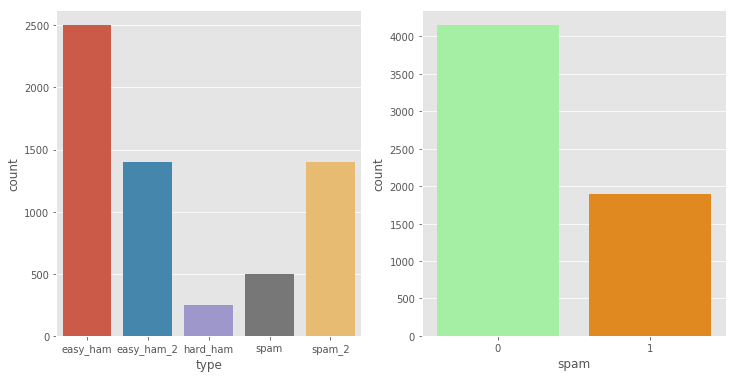

In [14]:
fig, ax_arr = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(df['type'], order=email_type, ax=ax_arr[0])
sns.countplot(df['spam'], palette=['palegreen', 'darkorange'], ax=ax_arr[1])
plt.show()

Before going further, let's create and keep aside the test dataset !

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['email'], df['spam'], stratify=df['spam'], 
                                                    test_size=0.2, shuffle=True, random_state=42)                                                       


*Reading back what I have done, here it would be a better call to stratify on df['type'] to ensure a balanced distribution between easy/hard spam/ham*

In [16]:
X_exp = X_train.copy()
X_spam = X_exp[y_train == 1].reset_index(drop=True)
for i in range(0, 101, 25):
    print(X_spam[i])
    print('~-'*30)

Let's have a quick look on simple and usefull information that might be contained in header e-mail : sender domain, content types and charset ! re library will allow us to play with regular expressions and build the relevant patterns to isolate these information. 

In [17]:
dom_p, cont_p, char_p = 'From .+@(\S+)',  'Content-Type:\s?([\w/]+)\;', 'charset="?([\w\-\_]+)"?'  
get_domain_sender = lambda x: re.findall(dom_p, x)[0].lower() if len(re.findall(dom_p, x)) != 0 else None
get_content_type = lambda x: re.findall(cont_p, x)[0].lower() if len(re.findall(cont_p, x)) != 0 else None
get_charset = lambda x: re.findall(char_p, x)[0].lower() if len(re.findall(char_p, x)) != 0 else None
print(get_domain_sender(X_spam[100]))
print(get_content_type(X_spam[100]), get_charset(X_spam[100]))


linux.ie
text/plain iso-8859-1


Functions to retrieve domain, content types and charset look to work fine. Let's dig for the full train_set

In [18]:
func_l = [get_domain_sender, get_content_type, get_charset]
df_exp = pd.concat([X_exp.map(func) for func in func_l], axis=1)
df_exp.columns = ['dom', 'cont', 'char']
display(df_exp.head(10))


,dom,cont,char
5644,None,text/html,iso-8859-1
2589,linux.ie,text/plain,iso-8859-1
2245,jmason.org,text/plain,None
2706,linux.ie,text/plain,iso-8859-15
1120,freshrpms.net,text/plain,us-ascii
5475,None,text/plain,iso-8859-1
4417,lists.sourceforge.net,text/html,iso-8859-9
5336,rocketmail.com,text/plain,windows-1252
3181,redhat.com,None,None
5671,None,text/html,us-ascii


In [19]:
def value_freq_graph(X0, X1, figsize=(10, 5)):
    """ Returns a graph for the value frequencies of 2 Series Ham/Spam from value_counts method """
    fig, ax_arr = plt.subplots(1, 2, figsize=figsize)
    sns.barplot(x= X0.values, y = X0.index, ax=ax_arr[0])
    sns.barplot(x= X1.values, y = X1.index, ax=ax_arr[1])
    ax_arr[0].set(xlabel='Frequencies', title='Ham')
    ax_arr[1].set(xlabel='Frequencies', title='Spam')
    plt.tight_layout()
    plt.show()

**Domain**

In [20]:
X0 = df_exp.loc[y_train == 0, 'dom'].value_counts(normalize=True)
X1 = df_exp.loc[y_train == 1, 'dom'].value_counts(normalize=True)

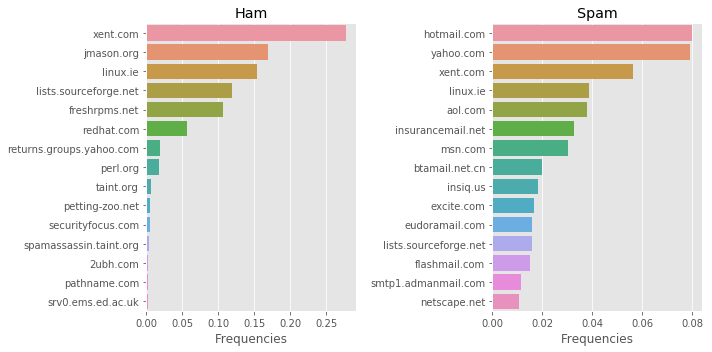

In [21]:
value_freq_graph(X0[:15], X1[:15])

In [22]:
susp_dom = [x for x in X1.index if x not in X0.index]
display(X1[susp_dom])
print("\n And what about hotmail.com in ham ? ", X0['hotmail.com'])

yahoo.com                     0.079148
aol.com                       0.038052
insurancemail.net             0.032725
msn.com                       0.030441
btamail.net.cn                0.019787
insiq.us                      0.018265
excite.com                    0.016743
eudoramail.com                0.015982
flashmail.com                 0.015221
smtp1.admanmail.com           0.011416
netscape.net                  0.010654
mail.com                      0.009893
caramail.com                  0.007610
yahoo.co.uk                   0.006088
mail.ru                       0.005327
freemail.nl                   0.005327
lycos.com                     0.005327
email.com                     0.005327
frugaljoe.330w.com            0.004566
freeuk.com                    0.003805
netzero.net                   0.003805
internationalfreecall.com     0.003805
bluemail.dk                   0.003805
firemail.de                   0.003044
permissionpass.com            0.003044
aeopublishing.com        


 And what about hotmail.com in ham ?  0.0006523157208088715


**Content type**

In [23]:
X0 = df_exp.loc[y_train == 0, 'cont'].value_counts(normalize=True)
X1 = df_exp.loc[y_train == 1, 'cont'].value_counts(normalize=True)

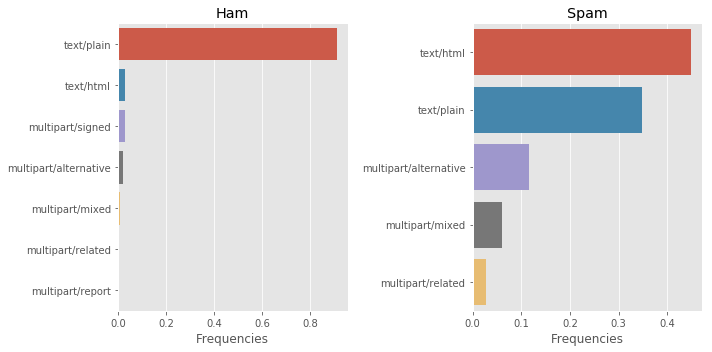

In [24]:
value_freq_graph(X0, X1)

**Charset**

In [25]:
X0 = df_exp.loc[y_train == 0, 'char'].value_counts(normalize=True)
X1 = df_exp.loc[y_train == 1, 'char'].value_counts(normalize=True)

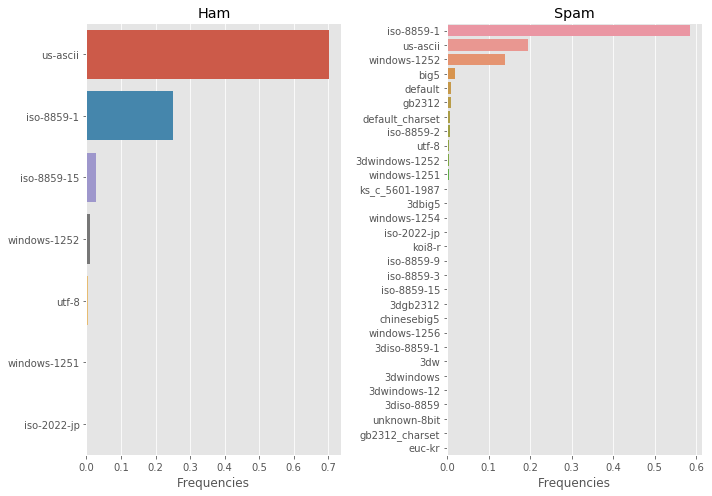

In [26]:
value_freq_graph(X0, X1, figsize=(10, 7))

### **Preprocessing the data in prevision of ML**

#### Definitions of a few functions and a class to preprocess the raw data

In [27]:
def get_header_subject_message(email):
    pattern = '\n{2}'
    separator = re.split(pattern, email, maxsplit=1)
    header, message = separator[0], separator[1]
    subjects = re.findall('Subject:\s(.*)\n', header)
    if len(subjects) != 0:
        subject = subjects[0]
    else:
        subject = ''
    return header, subject, message

In [28]:
header, subject, message = get_header_subject_message(X_train[20])
print(subject)
print('~-'*30)
print(header)
print('~-'*30)
print(message)

Re: [zzzzteana] Which Muppet Are You?
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-
From timc@2ubh.com  Thu Aug 22 17:31:00 2002
Return-Path: <timc@2ubh.com>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id A97BE43F99
	for <zzzz@localhost>; Thu, 22 Aug 2002 12:30:58 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 17:30:58 +0100 (IST)
Received: from n17.grp.scd.yahoo.com (n17.grp.scd.yahoo.com
    [66.218.66.72]) by dogma.slashnull.org (8.11.6/8.11.6) with SMTP id
    g7MGOFZ14344 for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 17:24:16 +0100
X-Egroups-Return: sentto-2242572-52744-1030033454-zzzz=spamassassin.taint.org@returns.groups.yahoo.com
Received: from [66.218.67.201] by n17.grp.scd.yahoo.com with NNFMP;
    22 Aug 2002 16:24:16 -0000
X-Sender: timc@2ubh.com
X-Apparently-To:

In [29]:
def get_dom_cont_char(header):
    pattern_d = {'dom_': 'From .+@(\S+)', 'cont_': 'Content-Type: ([\w/]+)\;', 'char_': 'charset="?([\w\-\_]+)"?'}
    get_results_d = {}
    for key, value in pattern_d.items():
        try_match = re.findall(value, header)
        if len(try_match) != 0:
            get_results_d[key] = try_match[0]
        else:
            get_results_d[key] = ' '
    return get_results_d.values()

In [30]:
dom, cont, char = get_dom_cont_char(header)
print (dom, cont, char)

2ubh.com text/plain US-ASCII


In [31]:
masking_url = lambda x: re.sub('\S*www\S+|http://\S+', 'urlmasked', x)
masking_number = lambda x: re.sub('\d+(?:[\s\,]?\d+)*(?:\.\d+)?', 'digitnumber', x)

In [32]:
print(message)

> Apols if this has been posted before:
> 
> http://www.pinkpaperclips.net/subs/quiz2.html
>
So, anyone who isn't Beaker?

TimC
Meep

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/ 






In [33]:
print(masking_number(masking_url(message)))

> Apols if this has been posted before:
> 
> urlmasked
>
So, anyone who isn't Beaker?

TimC
Meep

------------------------ Yahoo! Groups Sponsor ---------------------~-->
digitnumber DVDs Free +s&p Join Now
urlmasked
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to urlmasked 






**Let's build the preprocessing class with these functions**

In [34]:
class MessageSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keep_header=False, keep_subject=False, mask_number=True, mask_URL=True, add_main_par=True):
        self.keep_header = keep_header
        self.keep_subject = keep_subject
        self.mask_number = mask_number
        self.mask_URL = mask_URL
        self.add_main_par = add_main_par
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        ind = X.index
        X_mess = pd.Series(index=ind)
        for ix in ind:
            header, subject, content = get_header_subject_message(X[ix])
            domain, cont_type, character = get_dom_cont_char(header)
            main_sending_par = domain + ' ' + cont_type + ' ' + character
            if self.mask_URL:
                content, subject = masking_url(content), masking_url(subject)
            if self.mask_number:
                content, subject, header = masking_number(content), masking_number(subject), masking_number(header)
            if self.add_main_par & (not self.keep_header): #want to keep usefull par. while removing header
                content += '\n' + main_sending_par
            mail = self.keep_header * header + '\n' + self.keep_subject * subject + '\n' + content
            X_mess[ix] = mail
        return X_mess

In [35]:
X_mess = MessageSelector(keep_subject=True).fit_transform(X_train)
print(X_mess[20])



Re: [zzzzteana] Which Muppet Are You?
> Apols if this has been posted before:
> 
> urlmasked
>
So, anyone who isn't Beaker?

TimC
Meep

------------------------ Yahoo! Groups Sponsor ---------------------~-->
digitnumber DVDs Free +s&p Join Now
urlmasked
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to urlmasked 




2ubh.com text/plain US-ASCII


Finally we need to convert text into understandable values for a model. For that we will use the CountVectorizer class than will perform word tokenizing and occurence counting. 

In [36]:
count_vect = CountVectorizer()
X_train_count = count_vect.fit_transform(X_mess)
print(X_train_count.shape)
print(count_vect.vocabulary_.get('urlmasked'))
print(count_vect.vocabulary_.get('digitnumber'))

(4836, 87075)
77776
17786


Going further we can also add a Tfidf transformer to compute an ajusted word occurence frequency upon counting.

### **Building the ML model**

#### **Determining the short-list of most promising models**

In [37]:
algo_d = {
    'knn': KNeighborsClassifier(),
    'logit': LogisticRegression(),
    'sgd': SGDClassifier(random_state=42),
    'rf': RandomForestClassifier(n_estimators=500, random_state=42),
    'lin_svc': LinearSVC(loss='hinge'),
    'rbf_svc': SVC(gamma='auto'),
    'nb_m': MultinomialNB()
}
for key, clf in algo_d.items():
    spam_clf = Pipeline([
        ('mess_selector', MessageSelector()),
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', clf)
    ])
    print("\n", clf)
    cv = cross_val_score(spam_clf, X_train, y_train, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
    print("\n Accuracy - 5Fcv with {} : mean : {:.1f}%, Std : {:.2f}%".format(
        key, 100 * cv.mean(), 100 * np.std(cv)))
    print('~-'*30)


 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



 Accuracy - 5Fcv with knn : mean : 94.4%, Std : 0.76%
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-

 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



 Accuracy - 5Fcv with logit : mean : 96.5%, Std : 0.54%
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-

 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



 Accuracy - 5Fcv with sgd : mean : 98.4%, Std : 0.42%
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-

 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



 Accuracy - 5Fcv with rf : mean : 97.1%, Std : 0.57%
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-

 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



 Accuracy - 5Fcv with lin_svc : mean : 98.3%, Std : 0.37%
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-

 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



 Accuracy - 5Fcv with rbf_svc : mean : 68.6%, Std : 0.03%
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-

 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

 Accuracy - 5Fcv with nb_m : mean : 86.3%, Std : 0.94%
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished


Linear SVC sounds very promising ! Its stochastic "variant" here gives even slightly better results (randomness might help getting out of local optima ?) ! On the opposite, rbf svc acts like a dumb classifier, assuming everything is ham e-mail (most frequent target class).<br> <br>
Multinomial Naive Bayes classifier is a bit disappointing. It's known to work very well for text analysis. Multinomial NB classifier is suitable with discret features (like word counts) and multinomial distribution requires normal integer features counts but, in practice, fractional counts (like the ones provided by tf-idf) also work. Let's give a try with count vectors instead of fractionnal ones. I will also give a chance to bernoulli NB classifier with 0-1 counts.

In [38]:
Mnb_clf = Pipeline([
    ('mess_selector', MessageSelector()),
    ('vectorizer', CountVectorizer()),
    ('Mnb', MultinomialNB())
])

cv = cross_val_score(Mnb_clf, X_train, y_train, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
print("Accuracy - 5Fcv with Mnb : mean : {:.1f}%, Std : {:.2f}%".format(100 * cv.mean(), 100 * np.std(cv)))

Bnb_clf = Pipeline([
    ('mess_selector', MessageSelector()),
    ('vectorizer', CountVectorizer(binary=True)),
    ('Bnb', BernoulliNB())
])
cv = cross_val_score(Bnb_clf, X_train, y_train, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
print("Accuracy - 5Fcv with Bnb : mean : {:.1f}%, Std : {:.2f}%".format(100 * cv.mean(), 100 * np.std(cv)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy - 5Fcv with Mnb : mean : 94.4%, Std : 1.35%
Accuracy - 5Fcv with Bnb : mean : 86.8%, Std : 1.09%


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


Much better for the Multinomial NB clf ! <br> <br>
Although accuracy is not so terrible as a metric here (considering the rather balanced distribution of target classes, roughly 65 VS 35) but we should rely on a more robust metric including recall and precision. Let's have a look at precision-recall curves for our best classifiers at this stage of the study. I will keep SGD with hinge loss for linear SVC algo (no predict proba method for Linear SVC implying to use SVC class or probability calibration).

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


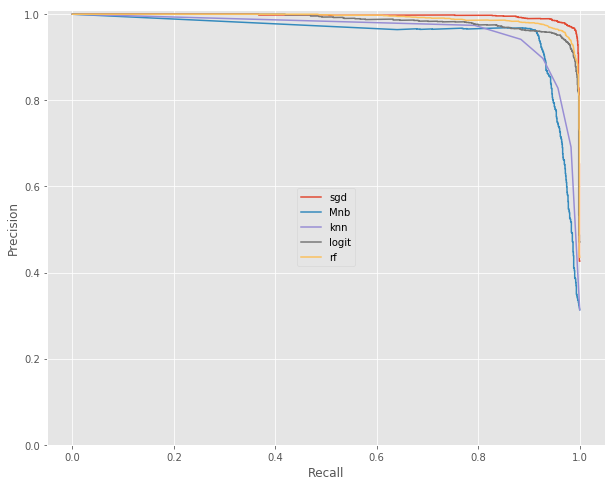

In [39]:
y_score_d = {}

sgd_clf = Pipeline([
    ('mess_selector', MessageSelector()),
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier(random_state=42))
])
y_score_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv=5, verbose=2, n_jobs=-1, method='decision_function')
y_score_d['sgd'] = y_score_sgd

y_proba_Mnb = cross_val_predict(Mnb_clf, X_train, y_train, cv=5, verbose=2, n_jobs=-1, method='predict_proba')
y_score_Mnb = y_proba_Mnb[:, 1]
y_score_d['Mnb'] = y_score_Mnb


algo_short_d = {
    'knn': KNeighborsClassifier(),
    'logit': LogisticRegression(),
    'rf': RandomForestClassifier(n_estimators=500, random_state=42)
}
for key, clf in algo_short_d.items():
    spam_clf = Pipeline([
        ('mess_selector', MessageSelector()),
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', clf)
    ])
    y_proba = cross_val_predict(spam_clf, X_train, y_train, cv=5, verbose=2, n_jobs=-1, method='predict_proba')
    y_score = y_proba[:, 1]
    y_score_d[key] = y_score
    
plt.figure(figsize=(10, 8))
for key, score in y_score_d.items():
    precisions, recalls, thresholds = precision_recall_curve(y_train, score)
    plt.plot(recalls, precisions, label=key)
plt.ylim([0, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='center')
plt.show()

SGD for linear SVC, Random Forests and Logit give the most promising results. Logit and SGD for linear SVC might be a bit a redundant here (linear svc should out-perform the logit anyway ...). I will only carry on with SGD and RF for this exercise. Extra spare time for computation could then be allocated to search the preprocessing parameter space. In a real-life study, LinearSVC classifier should also be investigated and one might even want to try mini-batch gradient descent !

#### **Fine-tuning the models**

*First, let's add a lemmatizer or stemmer that might slightly improve the models* 
<br>
As mentionned in Sklearn documentation : "Fancy token-level analysis such as stemming, lemmatizing, compound splitting, filtering based on part-of-speech, etc. are not included in the scikit-learn codebase, but can be added by customizing either the tokenizer or the analyzer".
Let's build custom classes for a token-lemmatizer/stemmer using NLTK.

In [40]:
class StemTokenizer(object):
    def __init__(self, stm=EnglishStemmer()):
        self.stm = stm
    def __call__(self, doc): 
        return [self.stm.stem(t) for t in word_tokenize(doc)]

In [41]:
class LemmaTokenizer(object):
    def __init__(self, wnl=WordNetLemmatizer()):
        self.wnl = wnl
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

These classes can be modified by replacing word_tokenize(doc) to CountVectorizer().build_analyzer()(doc)
<br>
In this case the custom class should be pass as an analyzer within CountVectorizer(). Here I prefered to keep hands on punctuation for further investigations and therefore choose to pass the custom class to tokenizer.

In [42]:
corpus = ["Where were your cats going ?",
          "They headed to the northern part of the city. And yours ?",
          "My cat did it once. It feels stronger then"]

stem_vectorizer = CountVectorizer(tokenizer=StemTokenizer())
stem_vectorizer.fit_transform(corpus)
print(stem_vectorizer.vocabulary_)
lem_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer())
lem_vectorizer.fit_transform(corpus)
print(lem_vectorizer.vocabulary_)

{'where': 21, 'were': 20, 'your': 22, 'cat': 3, 'go': 7, '?': 1, 'they': 18, 'head': 8, 'to': 19, 'the': 16, 'northern': 11, 'part': 14, 'of': 12, 'citi': 4, '.': 0, 'and': 2, 'my': 10, 'did': 5, 'it': 9, 'onc': 13, 'feel': 6, 'stronger': 15, 'then': 17}
{'where': 21, 'were': 20, 'your': 22, 'cat': 3, 'going': 7, '?': 1, 'they': 18, 'headed': 8, 'to': 19, 'the': 16, 'northern': 11, 'part': 14, 'of': 12, 'city': 4, '.': 0, 'and': 2, 'yours': 23, 'my': 10, 'did': 5, 'it': 9, 'once': 13, 'feel': 6, 'stronger': 15, 'then': 17}


Let's add a final option to our previous MessageSelector class to handle custom punctuation selection

In [43]:
class MessagePunctSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keep_header=False, keep_subject=False, add_main_par=True, keep_punct=False,
                 mask_number=True, mask_URL=True):
        self.keep_header = keep_header
        self.keep_subject = keep_subject
        self.mask_number = mask_number
        self.mask_URL = mask_URL
        self.add_main_par = add_main_par
        self.keep_punct = keep_punct
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        ind = X.index
        X_mess = pd.Series(index=ind)
        for ix in ind:
            header, subject, content = get_header_subject_message(X[ix])
            domain, cont_type, character = get_dom_cont_char(header)
            main_sending_par = domain + ' ' + cont_type + ' ' + character
            if self.mask_URL:
                content, subject = masking_url(content), masking_url(subject)
            if self.mask_number:
                content, subject, header = masking_number(content), masking_number(subject), masking_number(header)
            if not self.keep_punct:
                text_punct = '''!"#%&'()*+,-./:;<=>?@[\]^_`{|}~''' #want to keep $ for 'money' occurence
                header_punct = '''!"#$%&'()*+,:;<=>?@[\]^`{|}~''' #specific punctuation for header
                translator_text = str.maketrans(text_punct, ' '*len(text_punct)) #prefer empty space to None
                translator_header = str.maketrans(header_punct, ' '*len(header_punct)) #prefer empty space to None
                content, subject = content.translate(translator_text), subject.translate(translator_text)
                header = header.translate(translator_header)
            if self.add_main_par & (not self.keep_header):
                content += '\n' + main_sending_par
            mail = self.keep_header * header + '\n' + self.keep_subject * subject + '\n' + content
            X_mess[ix] = mail
        return X_mess

#### **Hyperparameter tuning**

Considering the large number of hyperparameters that could be modified throughout the preprocessing steps and the computation time required, fine tuning will be sliced in three consecutive GridsearchCV works. It's not the best approach but it should work just fine for this exercise. If extra time, another strategies could be to use a big parameter distribution and perform a large randomize search or to conduct the search in two steps : the first roughly determining best approximate buckets for parameters and the second to refine the first search. <br> <br>

Here I decided to firstly tune all the preprocessing parameters and then to look for the best hyperparameters of the clf.<br>
For metric I will go with the 'average_precision' score, corresponding to area under the precision-recall curve (equivalent to auc score for ROC curves, up to 1 and the higher the better !). Depending on final purpose, precision or recall would also have been relevant.

#### *Linear SVC with stochastic gradient descent*

In [44]:
sgd_clf = Pipeline([
    ('mess', MessagePunctSelector()),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier(random_state=42))
])
param_grid = [
    {'mess__keep_header': [True, False], 'mess__keep_subject': [True, False], 'mess__mask_URL': [True, False], 
     'mess__mask_number': [True, False], 'mess__keep_punct': [True, False], 'vect__lowercase': [True],
     'vect__tokenizer': [StemTokenizer(), LemmaTokenizer()]
     },
    {'mess__keep_header': [True, False], 'mess__keep_subject': [True, False], 'mess__mask_URL': [True, False], 
     'mess__mask_number': [True, False], 'mess__keep_punct': [True], 'vect__lowercase': [True], 
     'vect__tokenizer': [None], 'vect__token_pattern': ['\w\w+', '''\w\w+|[!"#%&'()*+,-./:;<=>?@[\]^_`{|}~]''']
     } #specific custom pattern for tokenization with/wo punctuation
]
cv = GridSearchCV(sgd_clf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='average_precision')
cv.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\ghare\Anaconda3\lib\s

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('mess', MessagePunctSelector(add_main_par=True, keep_header=False, keep_punct=False,
           keep_subject=False, mask_URL=True, mask_number=True)), ('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='...dom_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'mess__keep_header': [True, False], 'mess__keep_subject': [True, False], 'mess__mask_URL': [True, False], 'mess__mask_number': [True, False], 'mess__keep_punct': [True, False], 'vect__lowercase': [True], 'vect__tokenizer': [<__main__.StemTokenizer object at 0x00000258E366FA20>, <__main_...enizer': [None], 'vect__token_pattern': ['\\w\\w+', '\\w\\w+|[!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~]']}],
       pre_dispatch='2*n_jobs', refit=T

In [45]:
print('Best score : {:.2f}%, best parameters : {}'.format(cv.best_score_ * 100, cv.best_params_))

Best score : 99.82%, best parameters : {'mess__keep_header': True, 'mess__keep_punct': False, 'mess__keep_subject': False, 'mess__mask_URL': False, 'mess__mask_number': True, 'vect__lowercase': True, 'vect__tokenizer': <__main__.StemTokenizer object at 0x00000258E366FA20>}


In [46]:
sgd_clf = Pipeline([
    ('mess', MessagePunctSelector(keep_header=True, keep_subject=False, keep_punct=False, 
                                  mask_URL=False, mask_number=True)),
    ('vect', CountVectorizer(lowercase=True, tokenizer=StemTokenizer())),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier(random_state=42))
])
param_grid = [
    {'vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'vect__max_df': [1.0, 0.8, 0.6], 
     'vect__min_df': [1, 0.001, 0.005]
     }
]
cv = GridSearchCV(sgd_clf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='average_precision')
cv.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 47.0min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 107.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('mess', MessagePunctSelector(add_main_par=True, keep_header=True, keep_punct=False,
           keep_subject=False, mask_URL=False, mask_number=True)), ('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='...dom_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'vect__max_df': [1.0, 0.8, 0.6], 'vect__min_df': [1, 0.001, 0.005]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=2)

In [47]:
print('Best score : {:.2f}%, best parameters : {}'.format(cv.best_score_ * 100, cv.best_params_))

Best score : 99.86%, best parameters : {'vect__max_df': 0.6, 'vect__min_df': 0.001, 'vect__ngram_range': (1, 2)}


If available sparte time, you might want to investigate further max_df parameter for CountVectorizer...

In [48]:
prep_pip = Pipeline([
    ('mess', MessagePunctSelector(keep_header=True, keep_subject=False, keep_punct=False, 
                                  mask_URL=False, mask_number=True)),
    ('vect', CountVectorizer(lowercase=True, tokenizer=StemTokenizer(), 
                             max_df=0.6, min_df=0.001, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer())
])

X_prep = prep_pip.fit_transform(X_train)

In [49]:
sgd_clf = SGDClassifier(random_state=42)

param_grid = [
    {'alpha': 10.0**-np.arange(3, 6), 'penalty': ["l2"], 'loss': ["hinge", "squared_hinge"], 
     'early_stopping': [True, False], 'n_iter_no_change':[5], 'learning_rate': ['optimal', 'adaptive'], 
     'eta0': [0.05], 'max_iter':[5, 10**6//len(X_train), 1000]},
    {'alpha': 10.0**-np.arange(3, 6), 'penalty': ["elasticnet"], 'loss': ["hinge", "squared_hinge"], 
     'l1_ratio': [0.15, 0.25, 0.4], 'early_stopping': [True, False], 'n_iter_no_change':[5],
     'learning_rate': ['optimal', 'adaptive'],  'eta0': [0.05], 'max_iter':[5, 10**6//len(X_train), 1000]}
]
cv = GridSearchCV(sgd_clf, param_grid=param_grid, scoring='average_precision', cv=3, verbose=2, n_jobs=-1)
cv.fit(X_prep, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 58.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([1.e-03, 1.e-04, 1.e-05]), 'penalty': ['l2'], 'loss': ['hinge', 'squared_hinge'], 'early_stopping': [True, False], 'n_iter_no_change': [5], 'learning_rate': ['optimal', 'adaptive'], 'eta0': [0.05], 'max_iter': [5, 206, 1000]}, {'alpha': array([1.e-03, 1.e-04, 1.e-05]), 'p...change': [5], 'learning_rate': ['optimal', 'adaptive'], 'eta0': [0.05], 'max_iter': [5, 206, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
 

In [50]:
print('Best score : {:.2f}%, best parameters : {}'.format(cv.best_score_ * 100, cv.best_params_))

Best score : 99.88%, best parameters : {'alpha': 1e-05, 'early_stopping': False, 'eta0': 0.05, 'learning_rate': 'adaptive', 'loss': 'hinge', 'max_iter': 206, 'n_iter_no_change': 5, 'penalty': 'l2'}


In [51]:
sgd_clf_final = Pipeline([
    ('mess', MessagePunctSelector(keep_header=True, keep_subject=False, keep_punct=False, 
                                  mask_URL=False, mask_number=True)),
    ('vect', CountVectorizer(lowercase=True, tokenizer=StemTokenizer(), 
                             max_df=0.6, min_df=0.001, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier(random_state=42, alpha=1e-05, loss='hinge', max_iter=10**6//len(X_train),
                          penalty='l2', early_stopping=False, learning_rate='adaptive', n_iter_no_change=5,
                          eta0=0.05))
])
y_pred = cross_val_predict(sgd_clf_final, X_train, y_train, cv=5, verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.8min finished


In [52]:
print("Final accuracy score on validation set: {:.2f}%".format(accuracy_score(y_train, y_pred)*100))
print("Final precision score on validation set: {:.2f}%".format(precision_score(y_train, y_pred)*100))
print("Final recall score on validation set: {:.2f}%".format(recall_score(y_train, y_pred)*100))

Final accuracy score on validation set: 98.92%
Final precision score on validation set: 98.10%
Final recall score on validation set: 98.48%


In [53]:
y_score = cross_val_predict(sgd_clf_final, X_train, y_train, cv=3, verbose=2, n_jobs=-1, 
                            method='decision_function')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


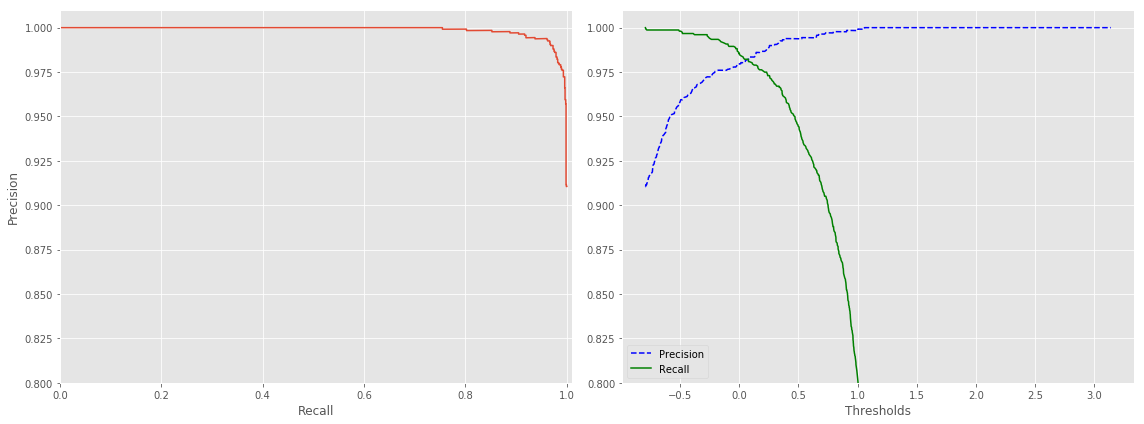

In [74]:
fig, ax_arr = plt.subplots(1, 2, figsize=(16, 6))
precisions, recalls, thresholds = precision_recall_curve(y_train, y_score)
ax_arr[0].plot(recalls, precisions, label='Final model with SGD classifier')
ax_arr[0].set(xlabel='Recall', ylabel='Precision', ylim=[0.8, 1.01], xlim=[0, 1.01])
ax_arr[1].plot(thresholds, precisions[:-1], "b--", label='Precision')
ax_arr[1].plot(thresholds, recalls[:-1], "g-", label='Recall')
ax_arr[1].set(xlabel='Thresholds', ylim=[0.8, 1.01])
ax_arr[1].legend(loc='best')
plt.tight_layout()
plt.show()

Threshold value can still be changed to aim at a specific precision/recall tradeoff. For example, let's try to reach a precision of 99%. Looking at the precision-recall/tresholds curves, the corresponding thresholds should be arount 0.3.

In [55]:
y_pred_99 = (y_score > 0.3)
print("New precision score on validation set: {:.2f}%".format(precision_score(y_train, y_pred_99)*100))
print("New recall score on validation set: {:.2f}%".format(recall_score(y_train, y_pred_99)*100))


New precision score on validation set: 99.06%
New recall score on validation set: 96.84%


In [56]:
FP_train = X_train[(y_train == 0) & (y_pred == 1)].reset_index(drop=True)
FN_train = X_train[(y_train == 1) & (y_pred == 0)].reset_index(drop=True)
print(len(FP_train), len(FN_train))

29 23


In [75]:
print(FP_train[0], FP_train[10], FP_train[20])

Return-Path: <mailer@desktopengineer.com>
Delivered-To: Jost.Krieger+freetechmail@ruhr-uni-bochum.de
Received: (qmail 8473 invoked by alias); 24 Jul 2002 00:13:25 -0000
Received: (qmail 8465 invoked by uid 82); 24 Jul 2002 00:13:25 -0000
Received: from mailer@desktopengineer.com by mailhost with qmail-scanner-1.00 (uvscan: v4.1.40/v4213. . Clean. Processed in 0.632524 secs); 24 Jul 2002 00:13:25 -0000
Received: from enterprisedesktop.com (HELO server1.enterprisedesktop.com) (209.61.182.209)
  by mi-1.rz.ruhr-uni-bochum.de with SMTP; 24 Jul 2002 00:13:24 -0000
Received: from localhost.localdomain (localhost [127.0.0.1])
	by server1.enterprisedesktop.com (8.11.3/8.11.3) with SMTP id g6O0D2k32482
	for <Jost.Krieger+freetechmail@ruhr-uni-bochum.de>; Tue, 23 Jul 2002 20:13:02 -0400
Message-Id: <200207240013.g6O0D2k32482@server1.enterprisedesktop.com>
Received: from Octeth Email Manager Pro ([207.34.72.13]) by www.desktopengineer.com with HTTP (Apache/1.3.22 (Unix)  (Red-Hat/Linux) mod_ssl/2

In [76]:
print(FN_train[0], FN_train[10], FN_train[20])

From rathcairn@eircom.net  Mon Jun 24 17:05:37 2002
Return-Path: rathcairn@eircom.net
Delivery-Date: Tue May 21 16:22:21 2002
Received: from mandark.labs.netnoteinc.com ([213.105.180.140]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4LFARe13905 for
    <jm@jmason.org>; Tue, 21 May 2002 16:10:29 +0100
Received: from mail03.svc.cra.dublin.eircom.net
    (mail03.svc.cra.dublin.eircom.net [159.134.118.19]) by
    mandark.labs.netnoteinc.com (8.11.2/8.11.2) with SMTP id g4LFA7D26547 for
    <jm@netnoteinc.com>; Tue, 21 May 2002 16:10:12 +0100
Received: (qmail 26210 messnum 563502 invoked from
    network[159.134.184.93/p93.as2.virginia1.eircom.net]); 21 May 2002
    15:09:42 -0000
Received: from p93.as2.virginia1.eircom.net (HELO r60qn) (159.134.184.93)
    by mail03.svc.cra.dublin.eircom.net (qp 26210) with SMTP; 21 May 2002
    15:09:42 -0000
Message-Id: <00c701c200d9$a14bd540$5db8869f@r60qn>
From: "rathcairn" <rathcairn@eircom.net>
To: "Zofia"
    <m22527@24h.co.jp>, <zen5@

In [59]:
def model_saver(model, saving_name, saving_path=MODEL_SAVING_PATH):
    from sklearn.externals import joblib
    os.makedirs(MODEL_SAVING_PATH, exist_ok=True)
    joblib.dump(model, os.path.join(saving_path, saving_name))
    print('Model saved in ', saving_path)

In [60]:
sgd_clf_final.fit(X_train, y_train)
model_saver(sgd_clf_final, 'sgd_clf.pkl')

Model saved in  ./Models/


#### *Random Forests*

In [61]:
rf_clf = Pipeline([
    ('mess', MessagePunctSelector()),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42))
])
param_grid = [
    {'mess__keep_header': [True, False], 'mess__keep_subject': [True, False], 'mess__mask_URL': [True, False], 
     'mess__mask_number': [True, False], 'mess__keep_punct': [True, False], 'vect__lowercase': [True],
     'vect__tokenizer': [StemTokenizer(), LemmaTokenizer()]
     },
    {'mess__keep_header': [True, False], 'mess__keep_subject': [True, False], 'mess__mask_URL': [True, False], 
     'mess__mask_number': [True, False], 'mess__keep_punct': [True], 'vect__lowercase': [True], 
     'vect__tokenizer': [None], 'vect__token_pattern': ['\w\w+', '''\w\w+|[!"#%&'()*+,-./:;<=>?@[\]^_`{|}~]''']
     } #specific custom pattern for tokenization with/wo punctuation
]
cv = GridSearchCV(rf_clf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='average_precision')
cv.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  3

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('mess', MessagePunctSelector(add_main_par=True, keep_header=False, keep_punct=False,
           keep_subject=False, mask_URL=True, mask_number=True)), ('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='...ators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'mess__keep_header': [True, False], 'mess__keep_subject': [True, False], 'mess__mask_URL': [True, False], 'mess__mask_number': [True, False], 'mess__keep_punct': [True, False], 'vect__lowercase': [True], 'vect__tokenizer': [<__main__.StemTokenizer object at 0x0000025883C08588>, <__main_...enizer': [None], 'vect__token_pattern': ['\\w\\w+', '\\w\\w+|[!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~]']}],
       pre_dispatch='2*n_jobs', refit=T

In [62]:
print('Best score : {:.2f}%, best parameters : {}'.format(cv.best_score_ * 100, cv.best_params_))

Best score : 99.35%, best parameters : {'mess__keep_header': True, 'mess__keep_punct': True, 'mess__keep_subject': True, 'mess__mask_URL': True, 'mess__mask_number': True, 'vect__lowercase': True, 'vect__token_pattern': '\\w\\w+', 'vect__tokenizer': None}


In [63]:
rf_clf = Pipeline([
    ('mess', MessagePunctSelector(keep_header=True, keep_subject=True, keep_punct=True, 
                                  mask_URL=True, mask_number=True)),
    ('vect', CountVectorizer(lowercase=True, tokenizer=None, token_pattern='\\w\\w+')),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42))
])
param_grid = [
    {'vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'vect__max_df': [1.0, 0.8, 0.6], 
     'vect__min_df': [1, 0.001, 0.005]
     }
]
cv = GridSearchCV(rf_clf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='average_precision')
cv.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 22.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('mess', MessagePunctSelector(add_main_par=True, keep_header=True, keep_punct=True,
           keep_subject=True, mask_URL=True, mask_number=True)), ('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='con...ators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'vect__max_df': [1.0, 0.8, 0.6], 'vect__min_df': [1, 0.001, 0.005]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=2)

In [64]:
print('Best score : {:.2f}%, best parameters : {}'.format(cv.best_score_ * 100, cv.best_params_))

Best score : 99.64%, best parameters : {'vect__max_df': 0.8, 'vect__min_df': 0.005, 'vect__ngram_range': (1, 2)}


In [65]:
rf_clf = Pipeline([
    ('mess', MessagePunctSelector(keep_header=True, keep_subject=True, keep_punct=True, 
                                  mask_URL=True, mask_number=True)),
    ('vect', CountVectorizer(lowercase=True, tokenizer=None, token_pattern='\\w\\w+')),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42))
])
param_grid = [
    {'vect__ngram_range': [(1, 2)], 'vect__max_df': [0.8, 0.6], 
     'vect__min_df': [0.005, 0.001]
     }
]
cv = GridSearchCV(rf_clf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='average_precision')
cv.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('mess', MessagePunctSelector(add_main_par=True, keep_header=True, keep_punct=True,
           keep_subject=True, mask_URL=True, mask_number=True)), ('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='con...ators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 2)], 'vect__max_df': [0.8, 0.6], 'vect__min_df': [0.005, 0.001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=2)

In [66]:
print('Best score : {:.2f}%, best parameters : {}'.format(cv.best_score_ * 100, cv.best_params_))

Best score : 99.64%, best parameters : {'vect__max_df': 0.8, 'vect__min_df': 0.005, 'vect__ngram_range': (1, 2)}


In [67]:
prep_pip = Pipeline([
    ('mess', MessagePunctSelector(keep_header=True, keep_subject=True, keep_punct=True, 
                                  mask_URL=True, mask_number=True)),
    ('vect', CountVectorizer(lowercase=True, tokenizer=None, token_pattern='\\w\\w+', 
                             max_df=0.8, min_df=0.005, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer())
])

X_prep = prep_pip.fit_transform(X_train)

In [68]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=500)


param_grid = {'max_features': ['auto', 'log2', 0.01], 
              'min_samples_split': [2, 0.05, 0.1, 0.15, 0.2], 'criterion': ['gini', 'entropy']}

cv = GridSearchCV(rf_clf, param_grid=param_grid, scoring='average_precision', cv=3, verbose=2, n_jobs=-1)
cv.fit(X_prep, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2', 0.01], 'min_samples_split': [2, 0.05, 0.1, 0.15, 0.2], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='average_precision', verbose=2)

In [69]:
print('Best score : {:.2f}%, best parameters : {}'.format(cv.best_score_ * 100, cv.best_params_))

Best score : 99.64%, best parameters : {'criterion': 'gini', 'max_features': 0.01, 'min_samples_split': 2}


In [70]:
rf_clf_final = Pipeline([
    ('mess', MessagePunctSelector(keep_header=True, keep_subject=True, keep_punct=True, 
                                  mask_URL=True, mask_number=True)),
    ('vect', CountVectorizer(lowercase=True, tokenizer=None, token_pattern='\\w\\w+', 
                             max_df=0.8, min_df=0.005, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=500, random_state=42, max_features=0.01))
])
y_pred = cross_val_predict(rf_clf_final, X_train, y_train, cv=5, verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


In [71]:
print("Final accuracy score on validation set: {:.2f}%".format(accuracy_score(y_train, y_pred)*100))
print("Final precision score on validation set: {:.2f}%".format(precision_score(y_train, y_pred)*100))
print("Final recall score on validation set: {:.2f}%".format(recall_score(y_train, y_pred)*100))

Final accuracy score on validation set: 98.01%
Final precision score on validation set: 96.65%
Final recall score on validation set: 97.03%


In [72]:
rf_clf_final.fit(X_train, y_train)
model_saver(rf_clf_final, 'rf_clf.pkl')

Model saved in  ./Models/


### **Evaluating the model on the test set**

In [73]:
y_test_pred = sgd_clf_final.predict(X_test)
print("Final accuracy score on test set: {:.2f}%".format(accuracy_score(y_test, y_test_pred)*100))
print("Final precision score on test set: {:.2f}%".format(precision_score(y_test, y_test_pred)*100))
print("Final recall score on test set: {:.2f}%".format(recall_score(y_test, y_test_pred)*100))

Final accuracy score on test set: 99.34%
Final precision score on test set: 98.69%
Final recall score on test set: 99.21%
